In [30]:
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import joblib
import matplotlib.pyplot as plt
import pickle

# DATA LABELLING

In [31]:
df = pd.read_csv('output/preprocessed_data23.csv')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

def assign_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def convert(polarity):
    if polarity == 'positive':
        return 1
    elif polarity == 'neutral':
        return 0
    else:
      return -1

df['sentiment'] = df['stemmed'].apply(lambda x: assign_sentiment(x))
df['polarity'] = df['sentiment'].apply(lambda x: convert(x))
df.head(5)

,full_text,created_at,cleaned,translated,case_fold,token,stop,stemmed,sentiment,polarity
0,Inilah 2 unit Rumah Tapak Jabatan Menteri yang...,Fri Mar 29 11:48:49 +0000 2024,Inilah 2 unit Rumah Tapak Jabatan Menteri yang...,b These are the 2 units of Landed Houses for M...,b these are the units of landed houses for mi...,"['b', 'these', 'are', 'the', 'units', 'of', 'l...","['b', 'units', 'landed', 'houses', 'ministeria...","['b', 'unit', 'land', 'hous', 'ministeri', 'po...",neutral,0
1,Alhamdulillah terima kasih berkenan mengunjung...,Fri Mar 29 02:34:41 +0000 2024,Alhamdulillah terima kasih berkenan mengunjung...,b Alhamdulillah thank you for visiting the Ind...,b alhamdulillah thank you for visiting the ind...,"['b', 'alhamdulillah', 'thank', 'you', 'for', ...","['b', 'alhamdulillah', 'thank', 'visiting', 'i...","['b', 'alhamdulillah', 'thank', 'visit', 'indo...",neutral,0
2,Pengamat Kritik 2 Proyek Milik Konglomerat Pen...,Thu Mar 28 23:39:00 +0000 2024,Pengamat Kritik 2 Proyek Milik Konglomerat Pen...,b Observers Criticize 2 Projects Owned by Cong...,b observers criticize projects owned by congl...,"['b', 'observers', 'criticize', 'projects', 'o...","['b', 'observers', 'criticize', 'projects', 'o...","['b', 'observ', 'critic', 'project', 'own', 'c...",positive,1
3,Wow‼️Terlihat dari pinggir jalan Gedung-gedung...,Thu Mar 28 06:04:01 +0000 2024,Wow Terlihat dari pinggir jalan Gedunggedung m...,b Wow Seen from the side of the road towering ...,b wow seen from the side of the road towering ...,"['b', 'wow', 'seen', 'from', 'the', 'side', 'o...","['b', 'wow', 'seen', 'side', 'road', 'towering...","['b', 'wow', 'seen', 'side', 'road', 'tower', ...",positive,1
4,Waktu ngedrone roll off trafo PLN di pelabuhan...,Thu Mar 28 03:03:32 +0000 2024,Waktu ngedrone roll off trafo PLN di pelabuhan...,b When droned to roll off a PLN transformer at...,b when droned to roll off a pln transformer at...,"['b', 'when', 'droned', 'to', 'roll', 'off', '...","['b', 'droned', 'roll', 'pln', 'transformer', ...","['b', 'drone', 'roll', 'pln', 'transform', 'ea...",negative,-1


In [32]:
df['sentiment'].value_counts()

sentiment
neutral     1750
positive    1365
negative     320
Name: count, dtype: int64

Text(0.5, 1.0, 'Persentase Masing-Masing Sentimen')

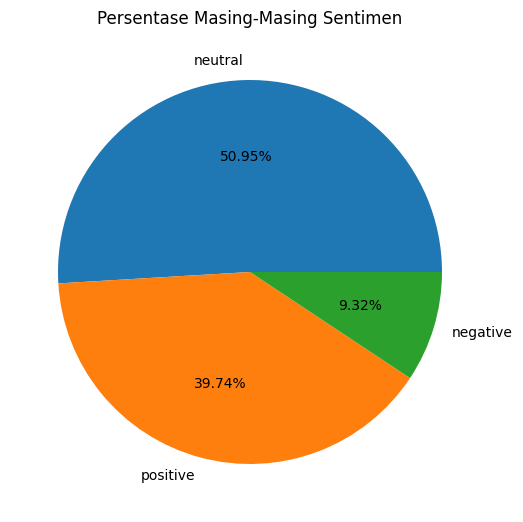

In [33]:
diagram = df['sentiment'].value_counts().rename_axis('nilai_sentimen').reset_index(name='jumlah')
label = diagram.nilai_sentimen
nilai = diagram.jumlah

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis = ('equal')

ax.pie(nilai, labels = label, autopct='%1.2f%%' )
ax.set_title("Persentase Masing-Masing Sentimen")

# SPLIT DATA

In [34]:
Train_X, Test_X, Train_Y, Test_Y =  model_selection.train_test_split(df['stemmed'], df['polarity'], test_size=0.2, random_state=30)

# TF-IDF VECTORIZER

In [35]:
# tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
tfidf = TfidfVectorizer()
tfidf.fit(df['stemmed'])

Train_X_Tfidf = tfidf.transform(Train_X)
Test_X_Tfidf = tfidf.transform(Test_X)

# Penerapan Model

In [36]:
hyperparameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svm = SVC()
svm_tuned = GridSearchCV(svm, hyperparameters)

In [37]:
svm_tuned.fit(Train_X_Tfidf, Train_Y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [38]:
svm = SVC(C=1, kernel='linear', degree=3, gamma='scale')
svm.fit(Train_X_Tfidf, Train_Y)

SVC(C=1, kernel='linear')

In [39]:
filename_svm = 'output/models/sklearn/model_svm_IKN.pkl'
pickle.dump(svm, open(filename_svm, 'wb'))

# Pengujian Model

In [40]:
loaded_model_svm = pickle.load(open(filename_svm, 'rb'))
result1 = loaded_model_svm.score(Test_X_Tfidf, Test_Y)
print(f'{result1* 100:.2f}%')

89.96%


# Evaluasi Model

In [41]:
predict_test1 = svm.predict(Test_X_Tfidf)

print("SVM Accuracy Score = ", accuracy_score(predict_test1, Test_Y)*100)
print("SVM Precision Score = ", precision_score(predict_test1, Test_Y, average='macro')*100)
print("SVM Recall Score = ", recall_score(predict_test1, Test_Y, average='macro')*100)
print("SVM f1 Score = ", f1_score(predict_test1, Test_Y, average='macro')*100)


SVM Accuracy Score =  89.95633187772926
SVM Precision Score =  78.41538196651832
SVM Recall Score =  93.69696124247285
SVM f1 Score =  82.90825313986942


In [42]:
report = classification_report(predict_test1, Test_Y)
print(report)

              precision    recall  f1-score   support

          -1       0.48      1.00      0.65        31
           0       0.98      0.86      0.92       413
           1       0.88      0.95      0.91       243

    accuracy                           0.90       687
   macro avg       0.78      0.94      0.83       687
weighted avg       0.93      0.90      0.91       687



Text(0.5, 1.0, 'Confusion Matrix for SVM Model')

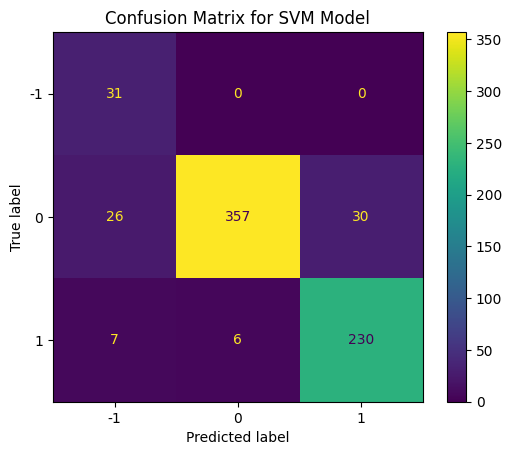

In [43]:
cm_display = ConfusionMatrixDisplay.from_predictions(predict_test1, Test_Y)
cm_display.ax_.set_title('Confusion Matrix for SVM Model')